### The codes used to calculate the measured OD when changing the input narrowband laser frequency. 
### A short pulse (2 $\mu$ s) is used to measure the transmitted signal amplitude.
The data saved from the scope: 
Channel 1 - trigger signal from HDAWG; Channel 2 - transmitted signal from balance detector (Monitor+); Channel 3 - reflected signal from balance detector  (Monitor-);

In [27]:
import os
import numpy as np
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Setting the path of the saved data file

In [28]:
dir = 'C:\\Users\\wj2002\\Dropbox (Heriot-Watt University Team)\\RES_EPS_Quantum_Photonics_Lab\\Experiments\\Current Experiments\\Broadband telecom quantum memories\\2023_Pr_YVO_Sectroscopy\\Visible\\0.1%'
folder = '0131_OD_laser'
path = dir + '\\' + folder + '\\'
file_list = os.listdir(path)
list_csv=natsorted([i for i in file_list if i.endswith('.CSV')]) # Sort the measured data file
file_size=np.shape(list_csv)

Plot_raw_data=1 # 1: plot the raw data

The measured laser frequencies by Thorlabs OSA, which should correspond the data file sorted above.

In [29]:
#freq=np.array([190.93889,190.94434,190.95711,190.96882,190.97931,190.98675,190.99255,190.99835,191.01219,191.01884,191.02698,191.03132,191.03703,191.04639,191.06055,191.06615]) # Unite: THz
freq=np.array([496.12010,496.12079,496.12150,496.12221,496.12293,496.12371,496.12449,496.12530,496.12612,496.12701,496.12782,496.12870,496.12959,496.13063]) # Unite: THz
#freq=np.array([495.13757, 495.14181, 495.14923, 495.16095, 495.16975, 495.17721, 495.18462, 495.19012, 495.19851, 495.20730]) # Unite: THz

Here, we need to read the reference trace for calculating the OD. We choose the data file when we the laser frequency is shifted to be off-resonant and also the laser polarisation is parallel to the crystal axis. 

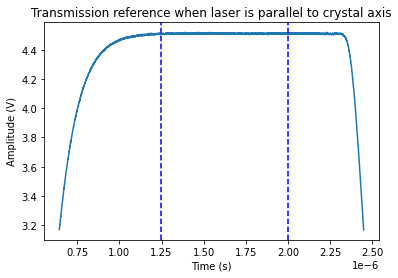

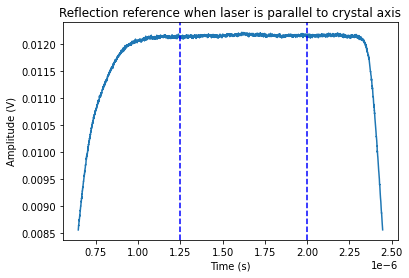

In [30]:
referece_file='OD013102.CSV'
ref_parallel=pd.read_csv(os.path.join(path,referece_file))
ref_parallel=ref_parallel.to_numpy()
transmitted_ref_parallel=ref_parallel[:,2]

T_max_ref_parallel=np.max(transmitted_ref_parallel)
mask1 = (transmitted_ref_parallel[:-1] < T_max_ref_parallel*0.7) & (transmitted_ref_parallel[1:] > T_max_ref_parallel*0.7)
mask2 = (transmitted_ref_parallel[:-1] > T_max_ref_parallel*0.7) & (transmitted_ref_parallel[1:] < T_max_ref_parallel*0.7)
Trigger_pos_T_ref_parallel=np.flatnonzero(mask1 | mask2)+1 # Lines 6~9 are used to find the rising and falling edges
Trigger_pos_T_ref_parallel_min=np.min(Trigger_pos_T_ref_parallel) # find the minimum value of the rising edge 
Trigger_pos_T_ref_parallel_max=np.max(Trigger_pos_T_ref_parallel) # find the maximum value of the falling edge
pos_T_ref_parallel_start=round(Trigger_pos_T_ref_parallel_min+(Trigger_pos_T_ref_parallel_max-Trigger_pos_T_ref_parallel_min)/3)
pos_T_ref_parallel_stop=round(Trigger_pos_T_ref_parallel_min+(Trigger_pos_T_ref_parallel_max-Trigger_pos_T_ref_parallel_min)*3/4) # choose the region of the measured trace for averaging to get the amplitude for OD calculation
T_ref_parallel_ave=np.average(transmitted_ref_parallel[pos_T_ref_parallel_start:pos_T_ref_parallel_stop])

reflected_ref_parallel=ref_parallel[:,3]
R_max_ref_parallel=np.max(reflected_ref_parallel)
mask1 = (reflected_ref_parallel[:-1] < R_max_ref_parallel*0.7) & (reflected_ref_parallel[1:] > R_max_ref_parallel*0.7)
mask2 = (reflected_ref_parallel[:-1] > R_max_ref_parallel*0.7) & (reflected_ref_parallel[1:] < R_max_ref_parallel*0.7)
Trigger_pos_R_ref_parallel=np.flatnonzero(mask1 | mask2)+1 # find the rising and falling edges
Trigger_pos_R_ref_parallel_min=np.min(Trigger_pos_R_ref_parallel) # find the minimum value of the rising edge 
Trigger_pos_R_ref_parallel_max=np.max(Trigger_pos_R_ref_parallel) # find the maximum value of the falling edge
pos_R_ref_parallel_start=round(Trigger_pos_R_ref_parallel_min+(Trigger_pos_R_ref_parallel_max-Trigger_pos_R_ref_parallel_min)/3)
pos_R_ref_parallel_stop=round(Trigger_pos_R_ref_parallel_min+(Trigger_pos_R_ref_parallel_max-Trigger_pos_R_ref_parallel_min)*3/4)
R_ref_parallel_ave=np.average(reflected_ref_parallel[pos_R_ref_parallel_start:pos_R_ref_parallel_stop])

normalised_reference=T_ref_parallel_ave/R_ref_parallel_ave
#Plot raw traces and also show the region between the two vertical dashed blue lines is used to calculated the averaged amplitude
if Plot_raw_data==1:

    fig,ax=plt.subplots()
    ax.plot(ref_parallel[Trigger_pos_T_ref_parallel_min:Trigger_pos_T_ref_parallel_max,0],ref_parallel[Trigger_pos_T_ref_parallel_min:Trigger_pos_T_ref_parallel_max,2])
    ax.axvline(ref_parallel[pos_T_ref_parallel_start,0],color='b',linestyle='dashed')
    ax.axvline(ref_parallel[pos_T_ref_parallel_stop,0],color='b',linestyle='dashed')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (V)')
    ax.set_title('Transmission reference when laser is parallel to crystal axis')
    
    fig,ax1=plt.subplots()
    ax1.plot(ref_parallel[Trigger_pos_R_ref_parallel_min:Trigger_pos_R_ref_parallel_max,0],ref_parallel[Trigger_pos_R_ref_parallel_min:Trigger_pos_R_ref_parallel_max,3])
    ax1.axvline(ref_parallel[pos_R_ref_parallel_start,0],color='b',linestyle='dashed')
    ax1.axvline(ref_parallel[pos_R_ref_parallel_stop,0],color='b',linestyle='dashed')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude (V)')
    ax1.set_title('Reflection reference when laser is parallel to crystal axis')

Here, we read the transmitted traces for calculating the OD.

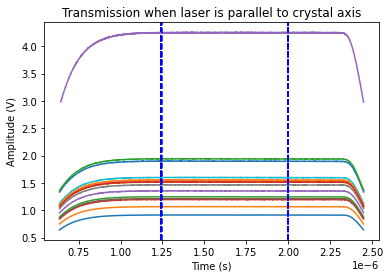

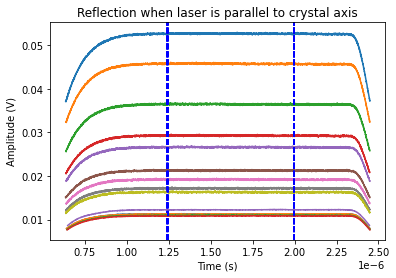

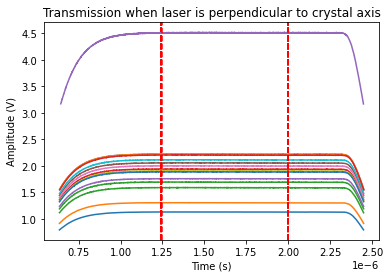

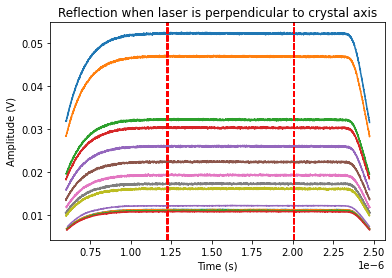

In [31]:
# Initialise the data saving array
T_parallel_ave=np.empty([int(file_size[0]/2),1])
T_perpendicular_ave=np.empty([int(file_size[0]/2),1])
R_parallel_ave=np.empty([int(file_size[0]/2),1])
R_perpendicular_ave=np.empty([int(file_size[0]/2),1])

if Plot_raw_data==1: # You can disable the plotting by set Plot_raw_data == 0
    fig,ax0=plt.subplots()
    fig,ax1=plt.subplots()
    fig,ax2=plt.subplots()
    fig,ax3=plt.subplots()

for index in range(int(file_size[0]/2)):
    data_parallel=pd.read_csv(os.path.join(path,list_csv[index*2])) # Read the data files when the laser polarisation is parallel to the crystal axis
    data_parallel=data_parallel.to_numpy()

    data_perpendicular=pd.read_csv(os.path.join(path,list_csv[index*2+1])) # Read the data files when the laser polarisation is perpendicular to the crystal axis
    data_perpendicular=data_perpendicular.to_numpy()

    time_parallel=data_parallel[:,0] # Read the time scale from the saved scope data
    time_perpendicular=data_perpendicular[:,0] 
    
    transmitted_parallel=data_parallel[:,2] # Read the measured transmitted traces (from the balance detector Monitor+) from the saved scope data, Channel 2
    transmitted_perpendicular=data_perpendicular[:,2]
    T_max_parallel=np.max(transmitted_parallel)
    T_max_perpendicular=np.max(transmitted_perpendicular)

    mask1 = (transmitted_parallel[:-1] < T_max_parallel*0.7) & (transmitted_parallel[1:] > T_max_parallel*0.7)
    mask2 = (transmitted_parallel[:-1] > T_max_parallel*0.7) & (transmitted_parallel[1:] < T_max_parallel*0.7)
    Trigger_pos_T_parallel=np.flatnonzero(mask1 | mask2)+1 # find the rising and falling edges
    Trigger_pos_T_parallel_min=np.min(Trigger_pos_T_parallel) # find the minimum value of the rising edge 
    Trigger_pos_T_parallel_max=np.max(Trigger_pos_T_parallel) # find the maximum value of the falling edge
    pos_T_parallel_start=round(Trigger_pos_T_parallel_min+(Trigger_pos_T_parallel_max-Trigger_pos_T_parallel_min)/3)
    pos_T_parallel_stop=round(Trigger_pos_T_parallel_min+(Trigger_pos_T_parallel_max-Trigger_pos_T_parallel_min)*3/4)
    T_parallel_ave[index]=np.average(transmitted_parallel[pos_T_parallel_start:pos_T_parallel_stop])
    
    mask1 = (transmitted_perpendicular[:-1] < T_max_perpendicular*0.7) & (transmitted_perpendicular[1:] > T_max_perpendicular*0.7)
    mask2 = (transmitted_perpendicular[:-1] > T_max_perpendicular*0.7) & (transmitted_perpendicular[1:] < T_max_perpendicular*0.7)
    Trigger_pos_T_perpendicular=np.flatnonzero(mask1 | mask2)+1
    Trigger_pos_T_perpendicular_min=np.min(Trigger_pos_T_perpendicular)
    Trigger_pos_T_perpendicular_max=np.max(Trigger_pos_T_perpendicular)
    pos_T_perpendicular_start=round(Trigger_pos_T_perpendicular_min+(Trigger_pos_T_perpendicular_max-Trigger_pos_T_perpendicular_min)/3)
    pos_T_perpendicular_stop=round(Trigger_pos_T_perpendicular_min+(Trigger_pos_T_perpendicular_max-Trigger_pos_T_perpendicular_min)*3/4)
    T_perpendicular_ave[index]=np.average(transmitted_perpendicular[pos_T_perpendicular_start:pos_T_perpendicular_stop])
    
    reflected_parallel=data_parallel[:,3] # Read the measured transmitted traces (from the balance detector Monitor+) from the saved scope data for normalising, Channel 3
    reflected_perpendicular=data_perpendicular[:,3]
    R_max_parallel=np.max(reflected_parallel)
    R_max_perpendicular=np.max(reflected_perpendicular)

    mask1 = (reflected_parallel[:-1] < R_max_parallel*0.7) & (reflected_parallel[1:] > R_max_parallel*0.7)
    mask2 = (reflected_parallel[:-1] > R_max_parallel*0.7) & (reflected_parallel[1:] < R_max_parallel*0.7)
    Trigger_pos_R_parallel=np.flatnonzero(mask1 | mask2)+1
    Trigger_pos_R_parallel_min=np.min(Trigger_pos_R_parallel)
    Trigger_pos_R_parallel_max=np.max(Trigger_pos_R_parallel)
    pos_R_parallel_start=round(Trigger_pos_R_parallel_min+(Trigger_pos_R_parallel_max-Trigger_pos_R_parallel_min)/3)
    pos_R_parallel_stop=round(Trigger_pos_R_parallel_min+(Trigger_pos_R_parallel_max-Trigger_pos_R_parallel_min)*3/4)
    R_parallel_ave[index]=np.average(reflected_parallel[pos_R_parallel_start:pos_R_parallel_stop])

    mask1 = (reflected_perpendicular[:-1] < R_max_perpendicular*0.6) & (reflected_perpendicular[1:] > R_max_perpendicular*0.6)
    mask2 = (reflected_perpendicular[:-1] > R_max_perpendicular*0.6) & (reflected_perpendicular[1:] < R_max_perpendicular*0.6)
    Trigger_pos_R_perpendicular=np.flatnonzero(mask1 | mask2)+1
    Trigger_pos_R_perpendicular_min=np.min(Trigger_pos_R_perpendicular)
    Trigger_pos_R_perpendicular_max=np.max(Trigger_pos_R_perpendicular)
    pos_R_perpendicular_start=round(Trigger_pos_R_perpendicular_min+(Trigger_pos_R_perpendicular_max-Trigger_pos_R_perpendicular_min)/3)
    pos_R_perpendicular_stop=round(Trigger_pos_R_perpendicular_min+(Trigger_pos_R_perpendicular_max-Trigger_pos_R_perpendicular_min)*3/4)
    R_perpendicular_ave[index]=np.average(reflected_perpendicular[pos_R_perpendicular_start:pos_R_perpendicular_stop])
    
    #Plot raw traces and also show the region between the two vertical dashed blue lines is used to calculated the averaged amplitude
    if Plot_raw_data==1:
        ax0.plot(time_parallel[Trigger_pos_T_parallel_min:Trigger_pos_T_parallel_max],transmitted_parallel[Trigger_pos_T_parallel_min:Trigger_pos_T_parallel_max])
        ax0.axvline(time_parallel[pos_T_parallel_start],color='b',linestyle='dashed')
        ax0.axvline(time_parallel[pos_T_parallel_stop],color='b',linestyle='dashed')

        ax1.plot(time_parallel[Trigger_pos_R_parallel_min:Trigger_pos_R_parallel_max],reflected_parallel[Trigger_pos_R_parallel_min:Trigger_pos_R_parallel_max],label='Reflection when laser is parallel to crystal axis')
        ax1.axvline(time_parallel[pos_R_parallel_start],color='b',linestyle='dashed')
        ax1.axvline(time_parallel[pos_R_parallel_stop],color='b',linestyle='dashed')

        ax2.plot(time_perpendicular[Trigger_pos_T_perpendicular_min:Trigger_pos_T_perpendicular_max],transmitted_perpendicular[Trigger_pos_T_perpendicular_min:Trigger_pos_T_perpendicular_max],label='Transmission when laser is perpendicular to crystal axis')
        ax2.axvline(time_perpendicular[pos_T_perpendicular_start],color='r',linestyle='dashed')
        ax2.axvline(time_perpendicular[pos_T_perpendicular_stop],color='r',linestyle='dashed')
        
        ax3.plot(time_perpendicular[Trigger_pos_R_perpendicular_min:Trigger_pos_R_perpendicular_max],reflected_perpendicular[Trigger_pos_R_perpendicular_min:Trigger_pos_R_perpendicular_max],label='Reflection when laser is perpendicular to crystal axis')
        ax3.axvline(time_perpendicular[pos_R_perpendicular_start],color='r',linestyle='dashed')
        ax3.axvline(time_perpendicular[pos_R_perpendicular_stop],color='r',linestyle='dashed')

        ax0.set_xlabel('Time (s)')
        ax0.set_ylabel('Amplitude (V)')
        ax0.set_title('Transmission when laser is parallel to crystal axis')

        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude (V)')
        ax1.set_title('Reflection when laser is parallel to crystal axis')
        
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Amplitude (V)')
        ax2.set_title('Transmission when laser is perpendicular to crystal axis')
        
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Amplitude (V)')
        ax3.set_title('Reflection when laser is perpendicular to crystal axis')
        
        fig.patch.set_facecolor('white')

ValueError: x and y must be the same size

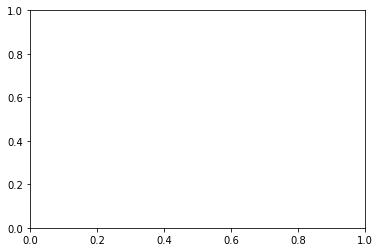

In [32]:
normalised_parallel=np.empty([int(file_size[0]/2),1])
normalised_perpendicular=np.empty([int(file_size[0]/2),1])
OD_parallel=np.empty([int(file_size[0]/2),1])
OD_perpendicular=np.empty([int(file_size[0]/2),1])
for index in range(int(file_size[0]/2)):
    normalised_parallel[index]=T_parallel_ave[index]/R_parallel_ave[index] # Do the normalisation of the transmitted signal over the reflected signal, to eliminate the power fluctuation 
    normalised_perpendicular[index]=T_perpendicular_ave[index]/R_perpendicular_ave[index]
    OD_parallel[index]=np.log(normalised_reference/normalised_parallel[index])
    OD_perpendicular[index]=np.log(normalised_reference/normalised_perpendicular[index])


fig,ax=plt.subplots()
ax.scatter(freq,OD_parallel,color='c', label='Laser polar. perpendicular to crystal axis')
ax.scatter(freq,OD_perpendicular,color='orange', label='Laser polar. parallel to crystal axis')
ax.legend(loc='upper left')
ax.set_ylim(-0.3,3.5)
ax.set_xlabel('Frequency [THz]')
ax.set_ylabel('OD')
ax.annotate('0.1% Pr3+:YVO4',
            xy=(1.057, 0.8), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='k')
fig.patch.set_facecolor('white')

c:\Users\wj2002\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


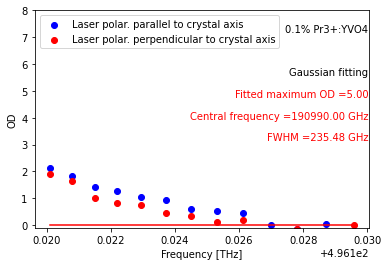

In [13]:
def gaussian(x, height, centre, sigma): # Do a Gaussian fitting here of the calculated OD
    '''Generates Gaussian with given parameters'''
    return height * np.exp(-(np.power(x - centre, 2) / (2 * sigma ** 2)))
OD_perpendicular_1=OD_perpendicular.flatten()
fit,success=curve_fit(gaussian,freq,OD_perpendicular_1,p0=[5,190.99,0.1]) 
freq_0=np.linspace(min(freq),max(freq),300)
fit_curve=fit[0]*np.exp(-(np.power(freq_0 - fit[1], 2) / (2 * fit[2] ** 2)))
FWHM=2*np.sqrt(2*np.log(2))*abs(fit[2])*1000 # Calculated FWHM based on the Gaussian fitting

fig,ax=plt.subplots()
ax.plot(freq_0,fit_curve,color='r')
ax.scatter(freq,OD_parallel,color='b', label='Laser polar. parallel to crystal axis')
ax.scatter(freq,OD_perpendicular,color='r', label='Laser polar. perpendicular to crystal axis')
ax.legend(loc='upper left')
ax.set_ylim(-0.1,8)
ax.set_xlabel('Frequency [THz]')
ax.set_ylabel('OD')
ax.annotate('FWHM ='+"{:.2f}".format(FWHM)+' GHz',
            xy=(1.057, 0.3), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='r')
fig.patch.set_facecolor('white')
ax.annotate('Central frequency ='+"{:.2f}".format(fit[1]*1000)+' GHz',
            xy=(1.057, 0.4), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='r')
fig.patch.set_facecolor('white')
ax.annotate('Fitted maximum OD ='+"{:.2f}".format(fit[0]),
            xy=(1.057, 0.5), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='r')
fig.patch.set_facecolor('white')
ax.annotate('Gaussian fitting',
            xy=(1.057, 0.6), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='k')
fig.patch.set_facecolor('white')
ax.annotate('0.1% Pr3+:YVO4',
            xy=(1.057, 0.8), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='k')
fig.patch.set_facecolor('white')

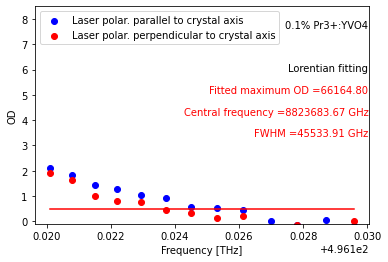

In [14]:
def lorentian(x, height, centre, Gmma): # Do a Lorentian fitting here of the calculated OD
    '''Generates Lorentian with given parameters'''
    return  height * ((Gmma/2)**2) / (np.power(centre-x, 2) + ((Gmma/2) ** 2))

OD_perpendicular_1=OD_perpendicular.flatten()
fit_lorentian,success_lorentian=curve_fit(lorentian,freq,OD_perpendicular_1,p0=[6,190.99,0.015])
freq_0=np.linspace(min(freq),max(freq),300)
fit_lorentian_curve= fit_lorentian[0]*((fit_lorentian[2]/2)**2) / (np.power(-freq_0 + fit_lorentian[1], 2) + ((fit_lorentian[2]/2) ** 2))
FWHM_lorentian=fit_lorentian[2]*1000

fig,ax=plt.subplots()
ax.plot(freq_0,fit_lorentian_curve,color='r')
ax.scatter(freq,OD_parallel,color='b', label='Laser polar. parallel to crystal axis')
ax.scatter(freq,OD_perpendicular,color='r', label='Laser polar. perpendicular to crystal axis')
ax.legend(loc='upper left')
ax.set_ylim(-0.1,8.5)
ax.set_xlabel('Frequency [THz]')
ax.set_ylabel('OD')
ax.annotate('FWHM ='+"{:.2f}".format(FWHM_lorentian)+' GHz',
            xy=(1.057, 0.3), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='r')
fig.patch.set_facecolor('white')
ax.annotate('Central frequency ='+"{:.2f}".format(fit_lorentian[1]*1000)+' GHz',
            xy=(1.057, 0.4), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='r')
fig.patch.set_facecolor('white')
ax.annotate('Fitted maximum OD ='+"{:.2f}".format(fit_lorentian[0]),
            xy=(1.057, 0.5), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='r')
fig.patch.set_facecolor('white')
ax.annotate('Lorentian fitting',
            xy=(1.057, 0.6), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='k')
fig.patch.set_facecolor('white')
ax.annotate('0.1% Pr3+:YVO4',
            xy=(1.057, 0.8), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom',color='k')
fig.patch.set_facecolor('white')